In [1]:
!pip install efficientnet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.6 MB/s eta 0:00:00


In [2]:
import cv2
import os
import numpy as np
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint, Callback
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.applications.densenet import DenseNet201
from imblearn.over_sampling import SMOTE

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
class MyCallback(Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch

        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.batches == 0 and epoch > 0:
            tr_acc = logs.get('accuracy')
            v_loss = logs.get('val_loss')

            if tr_acc > self.highest_tracc:
                self.highest_tracc = tr_acc

            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1
                self.best_weights = self.model.get_weights()
                self.count = 0
            else:
                self.count += 1

            if tr_acc >= self.threshold:
                self.ask_epoch -= 1

            if self.count == self.patience and self.ask_epoch > 0:
                print("\nEpoch %d: Accuracy threshold reached. Decreasing learning rate." % (epoch + 1))
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                new_lr = old_lr * self.factor
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                print("Learning rate decreased from %f to %f" % (old_lr, new_lr))
                self.count = 0

            if self.count == self.patience and self.ask_epoch == 0:
                self.stop_count += 1
                if self.stop_count == self.stop_patience:
                    print("\nTraining stopped at epoch %d" % (epoch + 1))
                    self.model.stop_training = True
                else:
                    print("\nEpoch %d: Learning rate adjustment limit reached. Restoring best weights." % (epoch + 1))
                    self.model.set_weights(self.best_weights)
                    self.count = 0

In [4]:
# Set the data path and categories
data_path = '/kaggle/input/koa-1500/MedicalExpert-I'
# List all the categories (subfolders) in the data folder
categories = os.listdir(data_path)

# Assign labels to the categories
labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories, labels))

img_size = 224
data = []
target = []

# Load the image data and labels
for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)

        try:
            # Convert the image to grayscale
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Convert the grayscale image to RGB by replicating the single channel three times
            rgb_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
            # Resize the image to the desired size
            resized_img = cv2.resize(rgb_img, (img_size, img_size))
            # Normalize the image
            normalized_img = resized_img / 255.0
            # Append the image and its corresponding label to the data and target lists
            data.append(normalized_img)
            target.append(label_dict[category])

        except Exception as e:
            print('Exception:', e)

In [5]:
# Convert the data and target lists to numpy arrays
data = np.array(data, dtype='float32')
target = np.array(target)

# Apply SMOTE oversampling to the data
smote = SMOTE(random_state=42)
data_res, target_res = smote.fit_resample(data.reshape(data.shape[0], -1), target)
data_res = data_res.reshape(data_res.shape[0], img_size, img_size, 3)
target_res = np_utils.to_categorical(target_res)

# Split the data into training, validation, and testing sets
x_train, x_test, y_train, y_test = train_test_split(data_res, target_res, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

# Construct the EfficientNetB3 model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3), pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(len(categories), activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

74836368/74836368 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               491776    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 18,822,725
Trainable params: 18,589,829
Non

In [6]:
# Define the callbacks
checkpoint = ModelCheckpoint('/kaggle/working/best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
my_callback = MyCallback(model=model, patience=10, stop_patience=5, threshold=0.9, factor=0.1, batches=10, epochs=100, ask_epoch=10)

# Train the model
history = model.fit(x_train, y_train, batch_size=16, epochs=100, validation_data=(x_val, y_val), callbacks=[checkpoint, my_callback])

Epoch 1/100
97/97 [==============================] - ETA: 0s - loss: 6.4848 - accuracy: 0.5344
Epoch 1: val_accuracy improved from -inf to 0.22957, saving model to /kaggle/working/best_model.h5
97/97 [==============================] - 172s 444ms/step - loss: 6.4848 - accuracy: 0.5344 - val_loss: 9.7623 - val_accuracy: 0.2296
Epoch 2/100
97/97 [==============================] - ETA: 0s - loss: 4.4605 - accuracy: 0.6958
Epoch 2: val_accuracy improved from 0.22957 to 0.28405, saving model to /kaggle/working/best_model.h5
97/97 [==============================] - 32s 329ms/step - loss: 4.4605 - accuracy: 0.6958 - val_loss: 7.9210 - val_accuracy: 0.2840
Epoch 3/100
97/97 [==============================] - ETA: 0s - loss: 3.5640 - accuracy: 0.8048
Epoch 3: val_accuracy improved from 0.28405 to 0.39689, saving model to /kaggle/working/best_model.h5
97/97 [==============================] - 32s 332ms/step - loss: 3.5640 - accuracy: 0.8048 - val_loss: 4.5996 - val_accuracy: 0.3969
Epoch 4/100
97/

In [7]:
'''batch_size = 40     # set batch size for training
epochs = 40         # number of all epochs in training
patience = 1 		    # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		    # factor to reduce lr by
ask_epoch = 5		    # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))'''

'batch_size = 40     # set batch size for training\nepochs = 40         # number of all epochs in training\npatience = 1 \t\t    # number of epochs to wait to adjust lr if monitored value does not improve\nstop_patience = 3 \t# number of epochs to wait before stopping training if monitored value does not improve\nthreshold = 0.9 \t  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss\nfactor = 0.5 \t\t    # factor to reduce lr by\nask_epoch = 5\t\t    # number of epochs to run before asking if you want to halt training\nbatches = int(np.ceil(len(train_gen.labels) / batch_size))'

In [8]:
# Load the best weights
model.load_weights('/kaggle/working/best_model.h5')

In [9]:
# Evaluate the model on the test set
val_loss, val_accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", val_loss)
print("Test accuracy:", val_accuracy)

Test loss: 0.5359371304512024
Test accuracy: 0.881322979927063


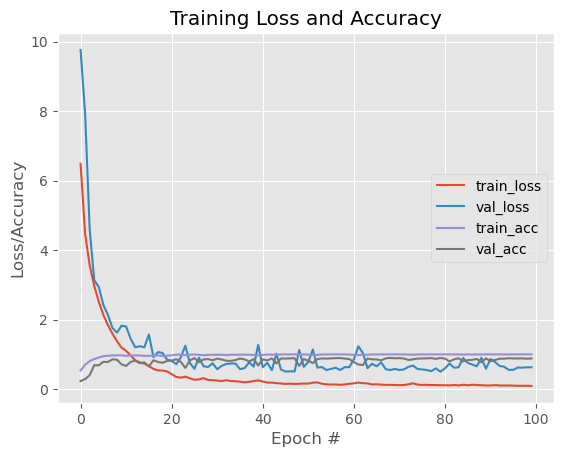

In [10]:
# Plot the training loss and accuracy
N = len(history.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("EfficientNet_Model")



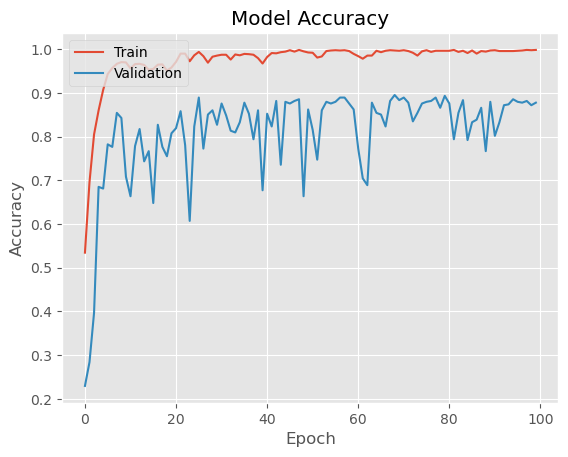

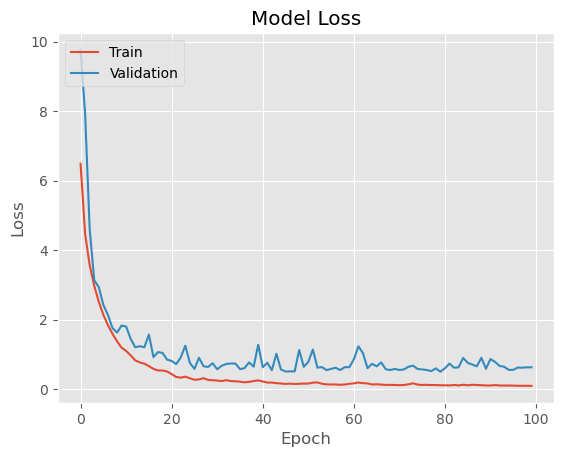

In [11]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
# Make predictions on the test data
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

17/17 [==============================] - 5s 141ms/step


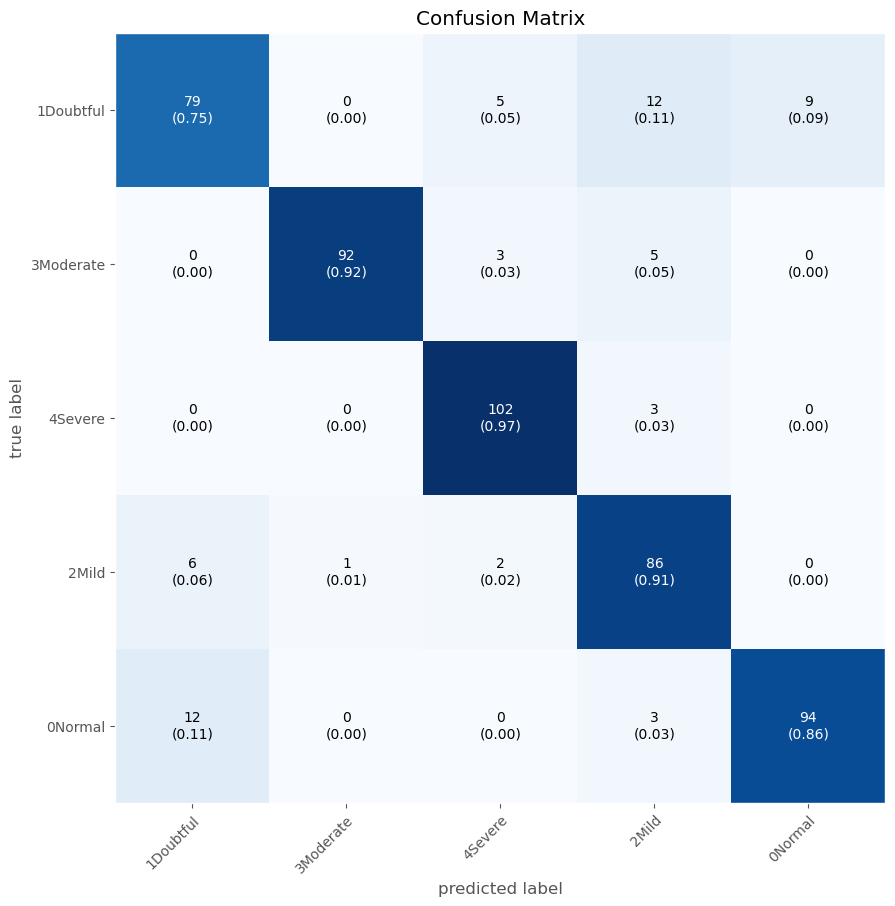

In [13]:
# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_mat=cm, class_names=categories, show_normed=True, figsize=(10, 10))
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Print the classification report
report = classification_report(y_true, y_pred, target_names=categories)
print(report)


              precision    recall  f1-score   support

   1Doubtful       0.81      0.75      0.78       105
   3Moderate       0.99      0.92      0.95       100
     4Severe       0.91      0.97      0.94       105
       2Mild       0.79      0.91      0.84        95
     0Normal       0.91      0.86      0.89       109

    accuracy                           0.88       514
   macro avg       0.88      0.88      0.88       514
weighted avg       0.88      0.88      0.88       514

